# Overview and Business Problem


The data science team has been tasked with creating a predictive model to determine the emotional sentiment behind tweets. The subjects of the tweets are Google and Apple products, and sentiment is largely classified binarily (tweets are defined as positive, negative, or neutral). By leveraging Natural Language Processing, the team analyzes specific word presences in each tweet in order to evaluate the author's emotional valence. The final model, then, is able to help evaluate overall group sentiment towards companies Apple and Google, along with some of their respective products.

# Data Understanding, Preparation, and Exploratory Analysis

## Data Understanding

Data for this analysis is sourced from data.world. It contains over 9,000 tweets from users regarding their feelings towards mainly Apple and Google products. Each data point contains the tweet in question, the targeted company or product, and pre-defined tweet sentiment. Sentiment is categorized as positive, negative, or neutral.

To begin the analysis, the team first cleans the sample data, removing confounding punctuation and null values, and then separates out tweets according to their target company.

In [1]:
# Import all relevant Python packages for workbook
!pip install gensim
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.linear_model import SGDClassifier
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import string, re
string.punctuation

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preparation

As a start, the team imports data in CSV format and immediately removes inconclusive data points (points with unclear sentiment). Data is then split up according to tweets' target company. With this separation, the team hopes to achieve a deeper and more accurate analysis of sentiment for each individual company. The operating logic is that, because the common vocabulary of a positive tweet for Google could differ from the common vocabulary of a common tweet for Apple, partitioning of the data per company will ultimately give way to a more robust set of models. For each data point, the team also removes confounding punctuation or words that do not contribute to the overall meaning of the tweet (removed words are known as "stop words").

The team finally decomposes each tweet into common root words via a process called lemmatization. With this cleaning, the team removes noise in the data set and ultimately distills each tweet into a more concise, meaningful grouping of data.

In [2]:
# Import data and remove tweets with unclassifiable sentiment
df = pd.read_csv('https://query.data.world/s/koumlilh5zav774mivuajaeahtefko',encoding= 'unicode_escape')
df = df[df.is_there_an_emotion_directed_at_a_brand_or_product != "I can't tell"]

In [3]:
# Separate data based on target company
apple=df[(df.emotion_in_tweet_is_directed_at=='iPad') | 
      (df.emotion_in_tweet_is_directed_at=='Apple') |
      (df.emotion_in_tweet_is_directed_at=='iPad or iPhone App') | 
      (df.emotion_in_tweet_is_directed_at=='iPhone') |
      (df.emotion_in_tweet_is_directed_at=='Other Apple product or service')]
google=df[(df.emotion_in_tweet_is_directed_at=='Google') | 
      (df.emotion_in_tweet_is_directed_at=='Other Google product or service') |
      (df.emotion_in_tweet_is_directed_at=='Android App') | 
      (df.emotion_in_tweet_is_directed_at=='Android')]

In [4]:
# Construct 'Stop Words' to remove confounding words and characters from data set
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)
stop_words += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©','2',2]
new_words=('sxsw','SXSW', 'mention','link','ipad','apple','quot','google','rt','quote','store','iphone')
for i in new_words:
    stop_words.append(i)

sw_set = set(stop_words)
stop_list = stop_words

In [5]:
# Construct filtering function to remove 'Stop Words' from each tweet
def process_article(article):
    article = re.sub(text_cleaning_re, ' ', str(article).lower()).strip()
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed

In [6]:
# Process data to remove 'Stop Words' and lemmatize resulting output to distill each tweet into more concise
# and meaningful root words
lemmatizer = WordNetLemmatizer() 

processed_data = list(map(process_article, df['tweet_text']))
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

apple.tweet_text=apple['tweet_text'].map(lambda x: lemmatizer.lemmatize(x))
google.tweet_text=google['tweet_text'].map(lambda x: lemmatizer.lemmatize(x))

C:\Users\admin\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The resulting output is then separated into target and feature variable sets. More specifically, tweet sentiment is defined as the overall target variable, whereas the tweets themselves are subject material for the feature set. In terms of company-based separation of the data set, these targets and features were separated further based on whether or not the subject was Google or Apple.

In [7]:
# Determine overall tweet sentiment target
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

# More granularly define target and feature set for Google-oriented tweets
gdata = google['tweet_text']
gtarget = google['is_there_an_emotion_directed_at_a_brand_or_product']

# More granularly define target and feature set for Apple-oriented tweets
adata = apple['tweet_text']
atarget = apple['is_there_an_emotion_directed_at_a_brand_or_product']

## Exploratory Data Analysis

The team then performs exploratory data analysis in order to gain a better understanding for the sample in general. To achieve this end, each tweet is decomposed into its corresponding lemmatized word counts. Word counts are then totalled to see if there is any observable correlation between the presence of certain words and the overall sentiment of the tweet. This analysis is performed for the overall data set as a whole, as for as for each target company.

In [8]:
# Decompose tweets into corresponding word counts
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
cv_apple = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer = token.tokenize)
cv_google = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['tweet_text'].values.astype('U'))
apple_text_counts= cv_apple.fit_transform(apple['tweet_text'])
google_text_counts= cv_google.fit_transform(google['tweet_text'])
total_df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())
apple_df = pd.DataFrame(apple_text_counts.todense(), columns = cv_apple.get_feature_names())
google_df = pd.DataFrame(google_text_counts.todense(),columns = cv_google.get_feature_names())

Initial, base analysis is performed on the data set. The team finds there is a large amount of null values for the data set in terms of discussed companies. This gap in info will not affect granular analysis of Apple and Google in particular (since that data has already been separately partitioned). As the sentiment of these data points is still present, the team includes these points in the overall analysis of the data as a whole. However, future analyses should ideally be conducted on a data set without this gap in info.

In [9]:
# Find presence of null values in the data set
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5655
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To gain a better idea of the share of undetermined or null companies compared to Apple's and Google's shares, the team plots these numbers out. As can be seen, target-undetermined tweets account for over 60% of the sample data. What is more, Apple-related products account for most of the defined tweet targets. To improve robustness of the models for future analysis, an equivalent sample size for each company should be taken, and null values for discussed company should be eliminated.

C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


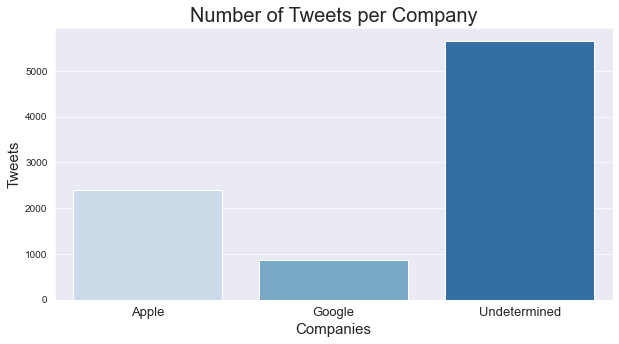

In [10]:
# Group relevant tweet targets under 'Apple' and 'Google' and 'Undefined' umbrellas
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Neither'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(df['brand'], palette = 'Blues')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
#plt.savefig('brands_viz.png')
plt.show()

Base target counts for the overall data set are next found. This allows the team to, from the onset, identify potential for class imbalance within the data. As can be seen, tweets with neutral sentiment (or an indefinable sentiment) are most common, numbering over five times the amount of the least-frequent, negative-sentiment tweets. The team recognizes this disparity and subsequent need to deal with class imbalance during model development.

C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


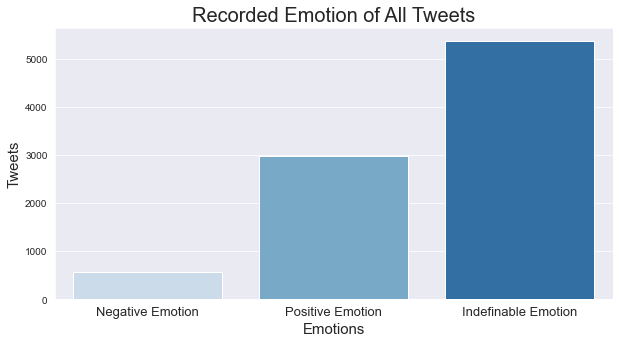

In [11]:
#Target Variable Countplot
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
all_count_viz = sns.countplot(df['is_there_an_emotion_directed_at_a_brand_or_product'], palette = 'Blues')
all_count_viz.set_title('Recorded Emotion of All Tweets',fontsize = 20)
all_count_viz.set_xlabel('Emotions',fontsize = 15)
all_count_viz.set_ylabel('Tweets',fontsize = 15)
all_count_viz.set_xticklabels(['Negative Emotion','Positive Emotion', 'Indefinable Emotion'],fontsize = 13)
#plt.savefig('all_count_viz.png')
plt.show()

The sentiment counts for Google and Apple specifically were then graphed. As can be seen, the team finds a large degree of class imbalance for both companies; each exhibited an overwhelming amount of positive-sentiment tweets. The team recognizes, again, the need to deal with class imbalance during model development as well as a potential future improvement for future data collection and further analysis.

Text(0.5, 1.0, 'Apple Tweet Sentiment Counts')

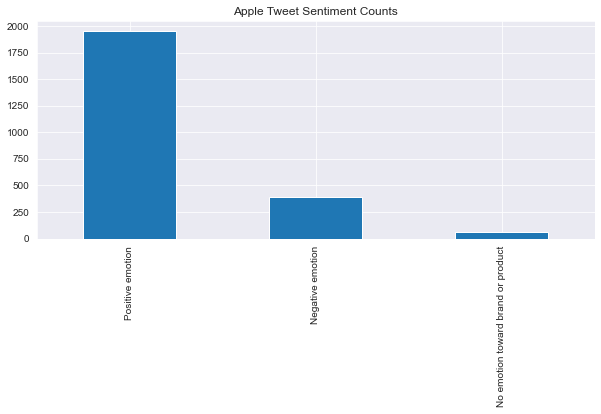

In [12]:
# Graph Apple sentiment counts for data set in order to identify potential class imbalance
plt.figure(figsize=(10,4))
apple['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(kind='bar')
plt.title('Apple Tweet Sentiment Counts')

Text(0.5, 1.0, 'Google Tweet Sentiment Counts')

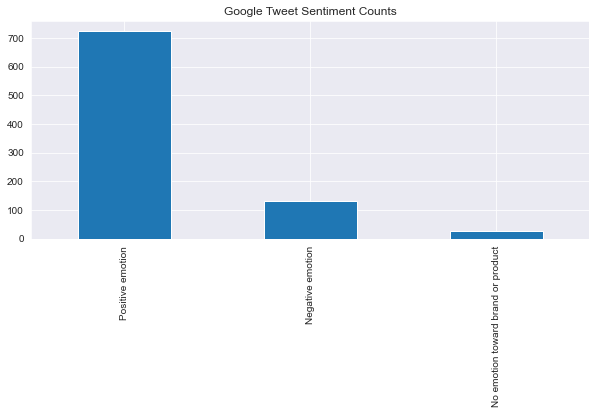

In [13]:
# Graph Google sentiment counts for data set in order to identify potential class imbalance
plt.figure(figsize=(10,4))
google['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(kind='bar')
plt.title('Google Tweet Sentiment Counts')

The team further decomposed positive- and negative-emotioned tweets into their specific corresponding products. As a reference, iPads ended up being the most positively tweeted producted, with a positive to negative tweet sentiment ratio of greater than 6 to 1.

In [14]:
# Define different product categories
import plotly.graph_objects as go
label = ["Apple", "Google",'iPad','Apple(General)','iPad or iPhone App','Google','iPhone',
         'Google Service', 'Android App','Android','Apple Service',
        'Negative Review','Positive Review']
source = [0,0,0,1,0,1,1,1,0,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10]
target_list = [2,3,4,5,6,7,8,9,10,11,12,11,12,11,12,11,12,11,12,11,12,11,12,11,12,11,12]
value = [918, 638, 460, 414, 287, 283, 80, 77, 34,125,793,95,543,63,397,68,346,103,184,47,236,8,72,8,69,2,32]

# Define graph colors
color_link = [
'#E2E2E2', '#E2E2E2', '#E2E2E2', '#E2E2E2',
'#E2E2E2', '#E2E2E2', '#E2E2E2', '#E2E2E2', '#E2E2E2',
'#E45756', '#00CC96', 
'#E45756', '#00CC96', 
'#E45756', '#00CC96', 
'#E45756', '#00CC96', 
'#E45756', '#00CC96', 
'#E45756', '#00CC96',
'#E45756', '#00CC96', 
'#E45756', '#00CC96',
'#E45756', '#00CC96',]

# Link company to product category to emotion
link = dict(source = source, target = target_list,value = value,color=color_link)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

# Plot figure
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Apple VS Google: Twitter Reviews",
    font=dict(size = 10, color = 'white'),
    paper_bgcolor='#5B5958'
)
fig.show()

ModuleNotFoundError: No module named 'plotly'

### Find Word Token Frequencies

The team extracted lemmatized tokens of words from the data set and observed based on sentiment grouping. The frequency counts for each of the tokens, the team then determines if there are any specific words that indicate particularly positive or negative sentiment. This analysis was performed for both the overall data set, as well as for Google and Apple individually.

In [15]:
# Split full data into different emotional sets
df_freq_positive = df[df['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive emotion']
df_freq_negative = df[df['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative emotion']
df_freq_neut = df[df['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion toward brand or product']

# Extract actual tweet text, separate based on emotion
data_positive = df_freq_positive['tweet_text']
data_negative = df_freq_negative['tweet_text']
data_neutral = df_freq_neut['tweet_text']

# Perform word counts for each emotional set of tweets
pros_positive = list(map(process_article, data_positive))
pros_negative = list(map(process_article, data_negative))
pros_neutral = list(map(process_article, data_neutral))

# Create sets of unique words for each emotional set
total_vocab_positive = set()
for comment in pros_positive:
    total_vocab_positive.update(comment)
len(total_vocab_positive)

total_vocab_negative = set()
for comment in pros_negative:
    total_vocab_negative.update(comment)
len(total_vocab_negative)

total_vocab_neutral = set()
for comment in pros_neutral:
    total_vocab_neutral.update(comment)
len(total_vocab_neutral)

flat_positive = [item for sublist in pros_positive for item in sublist]
flat_negative = [item for sublist in pros_negative for item in sublist]
flat_neutral = [item for sublist in pros_neutral for item in sublist]

# Find word frequencies for each emotional set
positive_freq = FreqDist(flat_positive)
negative_freq = FreqDist(flat_negative)
neutral_freq = FreqDist(flat_neutral)

In [16]:
# Calculate Percent Share of Frequent Tokens for Positive Sentiment
positive_total_word_count = sum(positive_freq.values())
positive_top_25 = positive_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in positive_top_25:
    normalized_frequency = word[1]/positive_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

app 		 0.01588
new 		 0.01429
austin 		 0.01179
pop 		 0.008496
amp 		 0.008377
ipad2 		 0.008377
android 		 0.008258
launch 		 0.006352
get 		 0.006273
one 		 0.005876
great 		 0.005439
party 		 0.00532
via 		 0.00524
line 		 0.00524
time 		 0.005082
free 		 0.005002
social 		 0.004923
circles 		 0.004843
cool 		 0.004764
like 		 0.004565
today 		 0.004526
day 		 0.004367
maps 		 0.004208
w 		 0.004129
mobile 		 0.004049


In [17]:
# Calculate Percent Share of Frequent Tokens for Negative Sentiment
negative_total_word_count = sum(negative_freq.values())
negative_top_25 = negative_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in negative_top_25:
    normalized_frequency = word[1]/negative_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

app 		 0.01189
new 		 0.008518
like 		 0.007726
circles 		 0.006735
social 		 0.006141
apps 		 0.005943
design 		 0.005745
people 		 0.005745
austin 		 0.005547
need 		 0.004952
android 		 0.004754
get 		 0.004754
one 		 0.004556
amp 		 0.004358
launch 		 0.004358
today 		 0.00416
would 		 0.003764
line 		 0.003566
news 		 0.003566
time 		 0.003566
think 		 0.003566
fail 		 0.003566
headaches 		 0.003368
1 		 0.003368
go 		 0.003368


In [18]:
# Calculate Percent Share of Frequent Tokens for Neutral Sentiment
neutral_total_word_count = sum(neutral_freq.values())
neutral_top_25 = neutral_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in neutral_top_25:
    normalized_frequency = word[1]/neutral_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

new 		 0.01504
austin 		 0.01404
amp 		 0.01331
social 		 0.01114
circles 		 0.01112
launch 		 0.0103
today 		 0.009769
app 		 0.007953
android 		 0.007953
network 		 0.007886
pop 		 0.007864
via 		 0.006247
called 		 0.006136
free 		 0.005804
line 		 0.005605
mobile 		 0.005294
ipad2 		 0.005228
sxswi 		 0.005117
major 		 0.005095
get 		 0.004674
party 		 0.004652
possibly 		 0.004231
check 		 0.003832
temporary 		 0.003766
opening 		 0.003655


In [19]:
# Create counts of Positive, Negative, and Neutral with values and words
positive_bar_counts = [x[1] for x in positive_freq.most_common(25)]
positive_bar_words = [x[0] for x in positive_freq.most_common(25)]

negative_bar_counts = [x[1] for x in negative_freq.most_common(25)]
negative_bar_words = [x[0] for x in negative_freq.most_common(25)]

neutral_bar_counts = [x[1] for x in neutral_freq.most_common(25)]
neutral_bar_words = [x[0] for x in neutral_freq.most_common(25)]

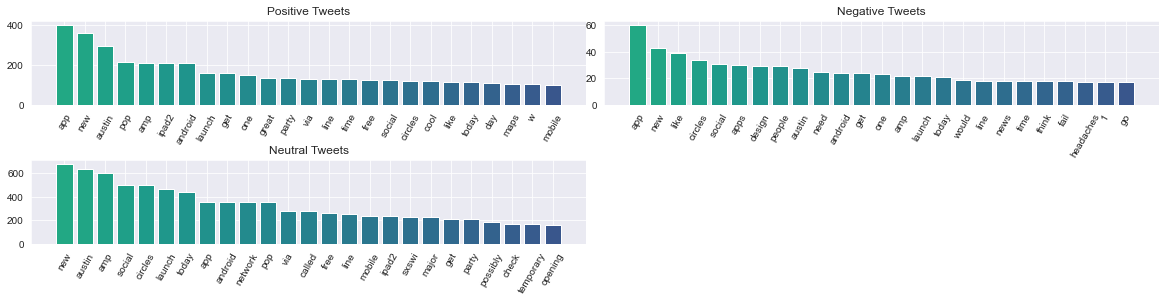

In [20]:
# Set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

# Initialize figure and subplots
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)

# Generate plots for the three subplots, including titles and axes
ax.bar(positive_bar_words, positive_bar_counts, color=color)
ax2.bar(negative_bar_words, negative_bar_counts, color=color )
ax3.bar(neutral_bar_words, neutral_bar_counts, color=color )

ax.title.set_text('Positive Tweets')
ax2.title.set_text('Negative Tweets')
ax3.title.set_text('Neutral Tweets')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

From overall analysis, the team finds one main valuable finding- tokens 'SXSW' and 'mention' appear most frequently for all sentiment classes of tweets. This leads the team to suspect that all data was collected at the South by Southwest music festival (or at least a promotional event for it). As these tokens occur at very frequent rates for every class, the team removed them from consideration in the analysis, as they didn't provide any differentiating worth for the different classes. Even so, the most frequent tokens are mainly common throughout all class types, thus supporting the need for individualized analysis between companies.

For a fast visual representation of most frequent words, word clouds are created for positive and negative classes, respectively.

In [21]:
# Getting our data into a dictionary
positive_dictionary = dict(zip(positive_bar_words, positive_bar_counts))
negative_dictionary = dict(zip(negative_bar_words, negative_bar_counts))

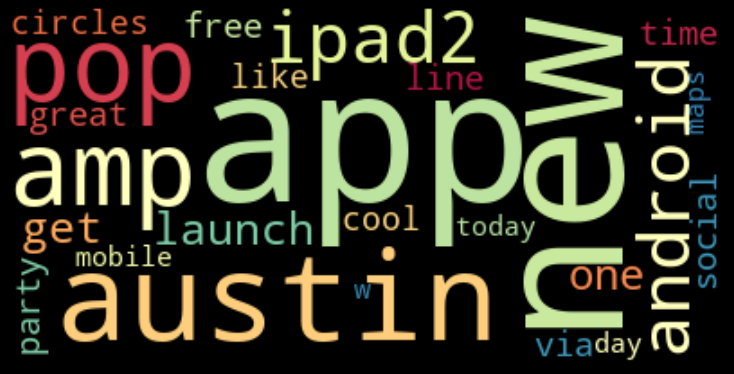

In [22]:
# Create the positive class word cloud:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(positive_dictionary)

# Display the generated image w/ matplotlib
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

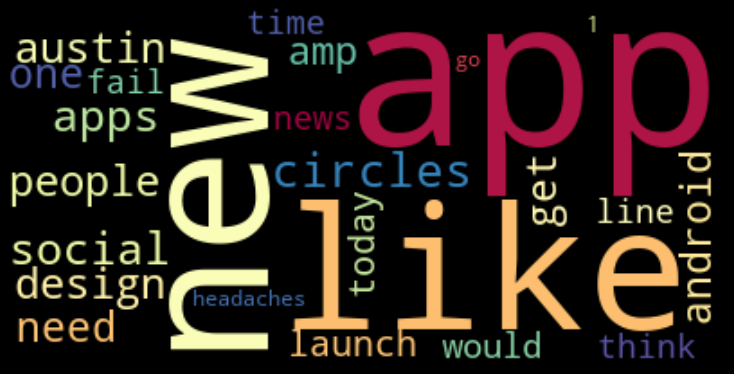

In [23]:
# Create the negative class word cloud
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(negative_dictionary)

# Display the generated image w/ matplotlib
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


## Apple Frequencies

Similar frequency analysis is performed for Apple-related tweets. Frequent word groupings show more diversity from sentiment class to sentiment class, which should lend to better differentiation of class based on the presence of particular tokens in a tweet.

In [56]:
afreqpos=apple[apple['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive emotion']
afreqneg=apple[apple['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative emotion']
afreqneut=apple[apple['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion toward brand or product']

adatapos=afreqpos.tweet_text
adataneg=afreqneg.tweet_text
adataneut=afreqneut.tweet_text

apos = list(map(process_article, adatapos))
aneg = list(map(process_article, adataneg))
aneut = list(map(process_article, adataneut))

atotal_vocab_pos = set()
for comment in apos:
    atotal_vocab_pos.update(comment)

atotal_vocab_neg = set()
for comment in aneg:
    atotal_vocab_neg.update(comment)

atotal_vocab_neut = set()
for comment in aneut:
    atotal_vocab_neut.update(comment)
    
flat_apos = [item for sublist in apos for item in sublist]
flat_aneg = [item for sublist in aneg for item in sublist]
flat_aneut = [item for sublist in aneut for item in sublist]

apos_freq = FreqDist(flat_apos)
aneg_freq = FreqDist(flat_aneg)
aneut_freq = FreqDist(flat_aneut)

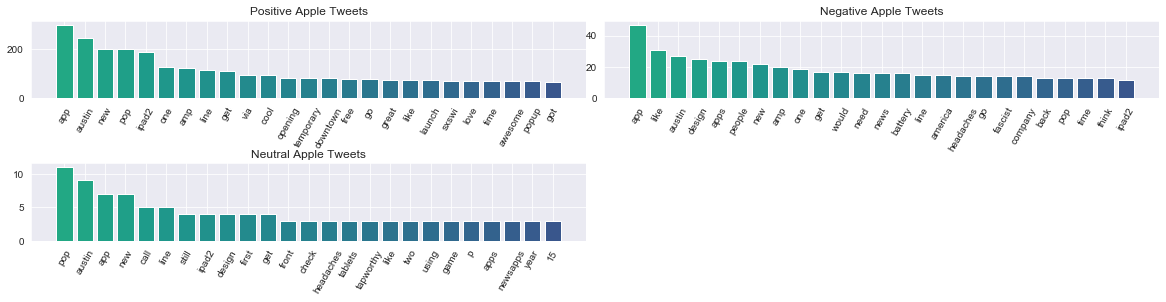

In [57]:
# create counts of Positive, Negative, and Neutral with values and words
positive_bar_counts = [x[1] for x in apos_freq.most_common(25)]
positive_bar_words = [x[0] for x in apos_freq.most_common(25)]

negative_bar_counts = [x[1] for x in aneg_freq.most_common(25)]
negative_bar_words = [x[0] for x in aneg_freq.most_common(25)]

neutral_bar_counts = [x[1] for x in aneut_freq.most_common(25)]
neutral_bar_words = [x[0] for x in aneut_freq.most_common(25)]

# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)

# Generate a line plot on first axes
ax.bar(positive_bar_words, positive_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(negative_bar_words, negative_bar_counts, color=color )

ax3.bar(neutral_bar_words, neutral_bar_counts, color=color )

ax.title.set_text('Positive Apple Tweets')
ax2.title.set_text('Negative Apple Tweets')
ax3.title.set_text('Neutral Apple Tweets')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('apple word count bar graphs.png')

plt.show()

## Google Word Frequencies

Similar frequency analysis is performed for Google-related tweets. Frequent word groupings show more diversity from sentiment class to sentiment class, which should lend to better differentiation of class based on the presence of particular tokens in a tweet.

In [24]:
gfreqpos=google[google['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive emotion']
gfreqneg=google[google['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative emotion']
gfreqneut=google[google['is_there_an_emotion_directed_at_a_brand_or_product']=='No emotion toward brand or product']

gdatapos=gfreqpos.tweet_text
gdataneg=gfreqneg.tweet_text
gdataneut=gfreqneut.tweet_text

gpos = list(map(process_article, gdatapos))
gneg = list(map(process_article, gdataneg))
gneut = list(map(process_article, gdataneut))

gtotal_vocab_pos = set()
for comment in gpos:
    gtotal_vocab_pos.update(comment)

gtotal_vocab_neg = set()
for comment in gneg:
    gtotal_vocab_neg.update(comment)

gtotal_vocab_neut = set()
for comment in gneut:
    gtotal_vocab_neut.update(comment)
    
flat_gpos = [item for sublist in gpos for item in sublist]
flat_gneg = [item for sublist in gneg for item in sublist]
flat_gneut = [item for sublist in gneut for item in sublist]

gpos_freq = FreqDist(flat_gpos)
gneg_freq = FreqDist(flat_gneg)
gneut_freq = FreqDist(flat_gneut)

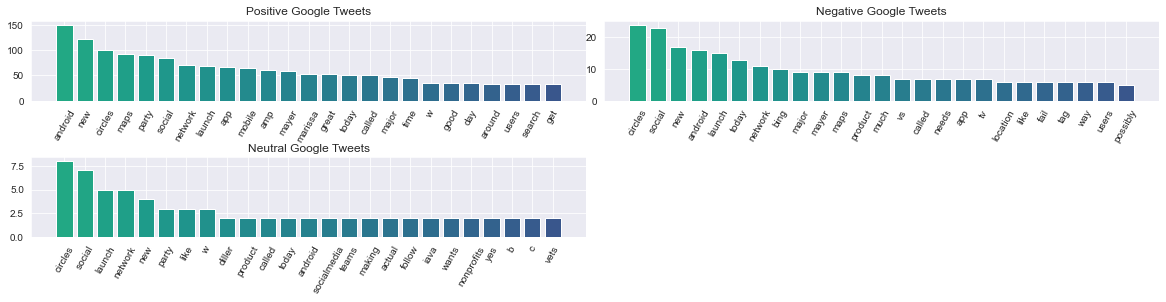

In [25]:
# create counts of Positive, Negative, and Neutral with values and words
positive_bar_counts = [x[1] for x in gpos_freq.most_common(25)]
positive_bar_words = [x[0] for x in gpos_freq.most_common(25)]

negative_bar_counts = [x[1] for x in gneg_freq.most_common(25)]
negative_bar_words = [x[0] for x in gneg_freq.most_common(25)]

neutral_bar_counts = [x[1] for x in gneut_freq.most_common(25)]
neutral_bar_words = [x[0] for x in gneut_freq.most_common(25)]

# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)

# Generate a line plot on first axes
ax.bar(positive_bar_words, positive_bar_counts, color=color)

# Draw a scatter plot on 2nd axes
ax2.bar(negative_bar_words, negative_bar_counts, color=color )

ax3.bar(neutral_bar_words, neutral_bar_counts, color=color )

ax.title.set_text('Positive Google Tweets')
ax2.title.set_text('Negative Google Tweets')
ax3.title.set_text('Neutral Google Tweets')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('apple word count bar graphs.png')

plt.show()

# Analysis and Model Development

After having analyzed the data, the team moves on to create predictive models that will classify tweet sentiment. First, a model is created using the entire data set as a reference. This serves as a baseline model against which individual models created for Google and Apple, respectively, will compare.

In all cases, data is first split into train and test sets. As false positive and negative rates are not incredibly important to consider in classifying tweet sentiment, accuracy is the main success criteria analyzed in models' performance. Due to the high degree of class imbalance found in the data set, F1 score is considered as a secondary success measure.

Linear SVC models were found to perform best with this data set, so SVC models were constructed in each iteration of modeling.

## Full Data Train Test Split

In [76]:
# Establish target and feature sets for full data set
X_lem = lemmatized_output
y_lem = target

# Split targets and features into training and testing sets
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.40, random_state=1)

## Full Data Pipeline Model

In [77]:
# Create SVC model out of vectorized training group for full data set
sentiments = ['Negative emotion','Positive Emotion','No emotion toward brand or product']
model = LinearSVC()

nb_pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', model)])
nb_pipeline.fit(X_train_lem, y_train_lem)


from sklearn.metrics import classification_report
y_pred = nb_pipeline.predict(X_test_lem)

# Print success measures for full data model
print('accuracy %s' % accuracy_score(y_pred, y_test_lem))
print(classification_report(y_test_lem, y_pred,target_names=sentiments))

accuracy 0.6657342657342658
                                    precision    recall  f1-score   support

                  Negative emotion       0.51      0.27      0.35       228
                  Positive Emotion       0.71      0.80      0.75      2164
No emotion toward brand or product       0.58      0.49      0.53      1183

                          accuracy                           0.67      3575
                         macro avg       0.60      0.52      0.55      3575
                      weighted avg       0.65      0.67      0.65      3575



The overall accuracy for SVC model of the full data set was found to be 67%. Since the percent share of the majority class for the full data set (neutral/undefined sentiment tweets) was found to be just over 60%, this model is not considered to be high performing. Further modeling of company-partitioned tweets is next attempted.

As such, training and testing sets are constructed for both Apple- and Google-related tweets.

## Apple Train Test

In [62]:
# Establish features and target in Apple data

aX=adata.values.astype('U')
ay=atarget.values.astype('U')

# Split features and target into training and testing partitions

aX_train, aX_test, ay_train, ay_test = train_test_split(aX, ay, random_state=1)

## Google Train Test

In [63]:
# Establish features and target in data

gX=gdata.values.astype('U')
gy=gtarget.values.astype('U')

# Split features and target into training and testing partitions

gX_train, gX_test, gy_train, gy_test = train_test_split(gX, gy, random_state=1)

Similar to the overall data set's model, linear SVC models are created for both Apple and Google, and the corresponding measures of success are printed.

## Apple Pipeline Model

In [84]:
# Create SVC model out of vectorized training group for Apple data set
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
model = LinearSVC()
dummy_clf = DummyClassifier(strategy="most_frequent")

nb_pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', model)])

nb_pipeline.fit(aX_train, ay_train)

ay_pred = nb_pipeline.predict(aX_test)

# Print success measures for Apple data model
print('accuracy %s' % accuracy_score(ay_pred, ay_test))
print(classification_report(ay_test, ay_pred,target_names=sentiments))

accuracy 0.8569051580698835
                                    precision    recall  f1-score   support

                  Negative emotion       0.69      0.44      0.54        97
                  Positive Emotion       0.00      0.00      0.00        15
No emotion toward brand or product       0.88      0.97      0.92       489

                          accuracy                           0.86       601
                         macro avg       0.52      0.47      0.49       601
                      weighted avg       0.83      0.86      0.84       601



## Google Pipeline Model

In [79]:
# Create SVC model out of vectorized training group for Google data set
model = LinearSVC()

nb_pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', model)])

nb_pipeline.fit(gX_train, gy_train)

gy_pred = nb_pipeline.predict(gX_test)
sentiments = ['Negative emotion','Positive Emotion','No emotion toward brand or product']

# Print success measures for Google data model
print('accuracy %s' % accuracy_score(gy_pred, gy_test))
print(classification_report(gy_test, gy_pred,target_names=sentiments))

accuracy 0.85
                                    precision    recall  f1-score   support

                  Negative emotion       0.76      0.34      0.47        38
                  Positive Emotion       0.50      0.20      0.29         5
No emotion toward brand or product       0.86      0.98      0.92       177

                          accuracy                           0.85       220
                         macro avg       0.71      0.51      0.56       220
                      weighted avg       0.84      0.85      0.82       220



When creating company-based models, it is seen that accuracy sees a jump of nearly 20%; both models show values of around 85%. However, class imbalance still seems to adversely impact model robustness, as averaged F1-Score for both models across classes is around 52%.

A dummy linear SVC model for Apple and Google produces an accuracy of 81% and an average F1-Score of 30%. Therefore, the partitioned models perform reasonably well with room for improvement (again, mainly due to presence of class imbalance within the data set).

To further explore the  possible effect of class imbalance on the models' abilities to predict, confusion matrices are produced for each model.

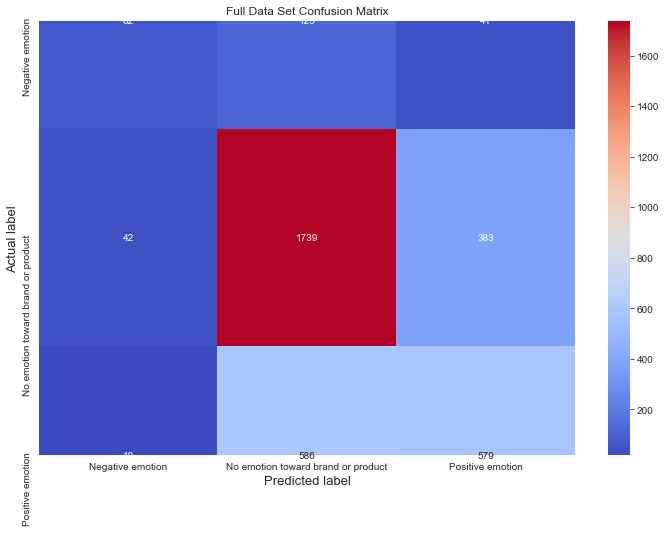

In [80]:
#Generate confusion matrix for full data set
labels = np.unique(y_test_lem)
cm = confusion_matrix(y_test_lem, y_pred,labels=labels) 

cm_df = pd.DataFrame(cm,index=labels, columns=labels)

#Plot
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df,
            cmap='coolwarm', 
            annot=True, 
            fmt='g')

plt.ylabel('Actual label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.title('Full Data Set Confusion Matrix')
plt.show()

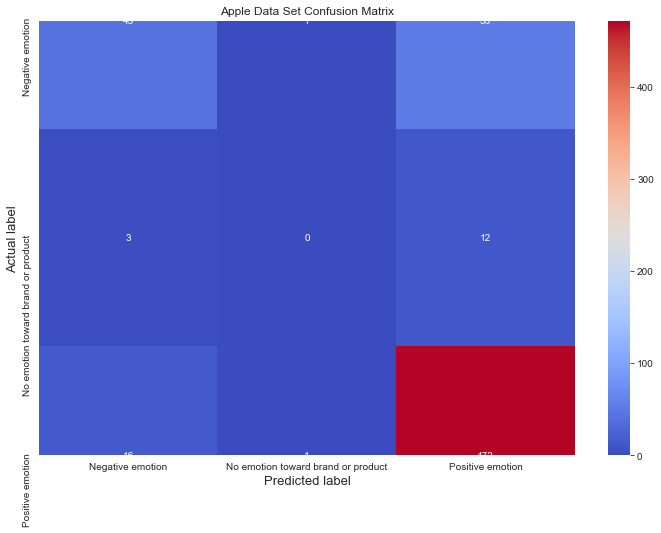

In [81]:
#Generate confusion matrix
alabels = np.unique(ay_test)
acm = confusion_matrix(ay_test, ay_pred, labels=alabels) 

acm_df = pd.DataFrame(acm,index=alabels, columns=alabels)

#Plot
plt.figure(figsize=(12, 8))

sns.heatmap(acm_df,
            cmap='coolwarm', 
            annot=True, 
            fmt='g')

plt.ylabel('Actual label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.title('Apple Data Set Confusion Matrix')
plt.show()

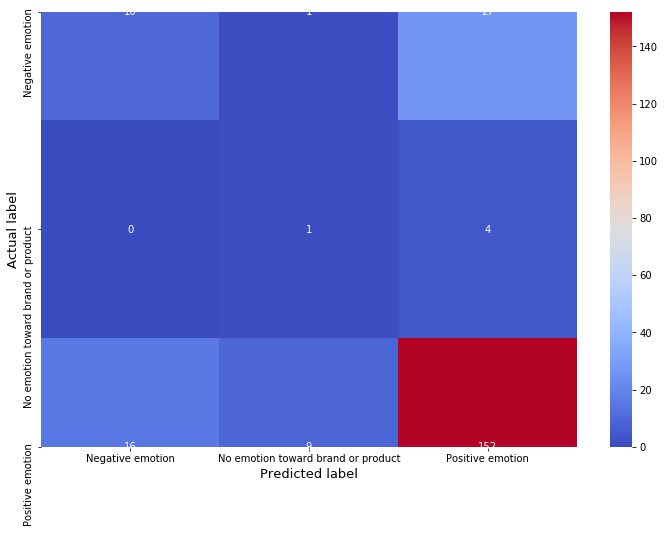

In [130]:
#Generate confusion matrix
glabels = np.unique(gy_test)
gcm = confusion_matrix(gy_test, gy_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

sns.heatmap(gcm_df,
            cmap='coolwarm', 
            annot=True, 
            fmt='g')

plt.ylabel('Actual label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.title('Google Data Set Confusion Matrix')
plt.show()

As may be expected, all models perform best when truly predicting the majority class (neutral/undefined tweets for the full data set and positive tweets for the Apple and Google data sets).

To root out the cause of mis-categorization on part of the models, the team analyzes wrongly categorized tweets individually. The following tweet was deemed representative of this mis-categorization and was wrongly defined as having positive sentiment when, in reality, it showed negative sentiment.

In [82]:
df.tweet_text[8930]

'#iPad #news #apps not popular with the #kids. {link} #the_daily is a terrible concept anyway #sxsw'

As can be seen, the unigram 'popular' is included in this tweet. 'Popular' has been defined as a positive-sentiment-indicating token by the produced models, which is likely the reason this tweet was defined as having positive sentiment. However, presence of the token 'not' directly before this unigram reverses the effective meaning of the tweet. Since the bigram 'not popular' does not appear very often within the data set, models likely do not stress this sequence of tokens as being very impactful. To improve performance, models should be constructed such that they take tokens like 'not' (i.e. ones that effectively reverse the meaning of the entire tweet) better into account.

# Summary and Conclusion

Overall, a reasonably well model and representation of the data is achieved by partitioning the data set by company (Apple and Google) and using linear SVC analysis. Models for constituent companies produced an average accuracy of 86% and F1-Score of around 52% across all sentiment classes. These models outperform the model created for the entire data set, which only achieved an accuracy of 67% and an F1-Score of ~54%. They also outperformed a dummy model that blindly predicted the majority class, which achieved an accuracy of 81% and an average F1-Score of 30% across all classes.

Analysis is mainly hampered by two factors. The first is a large degree of class imbalance within the data. To improve in future model iterations, it is advised that tweet data is collected in a more unbiased manner; the high degree of positive tweets for both Apple and Google is likely due to the fact that tweets were created for a festival promotional event, wherein it appears that free products were being given out to participants. Data points should ideally be collected over a longer period of time and should be independent of one another (i.e. they shouldn't have all been written on account of the same event).

The second factor hampering performance is the lack of the models' ability to rightfully weight certain tokens that reverse a tweet's meaning (as in the example where the presence of 'not' changed the true meaning of a tweet from positive to negative). Such an analysis would consider such words not necessarily as parts of larger bigrams, but as unique unigrams that reverse the valence of other nearby unigrams (like 'popular' in the analyzed example).